# Skin Cancer
link to data: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

### Overview
Another more interesting than digit classification dataset to use to get biology and medicine students more excited about machine learning and image processing.

### Original Data Source
Original Challenge: https://challenge2018.isic-archive.com
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T [1] Noel Codella, Veronica Rotemberg, Philipp Tschandl, M. Emre Celebi, Stephen Dusza, David Gutman, Brian Helba, Aadi Kalloo, Konstantinos Liopyris, Michael Marchetti, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection 2018: A Challenge Hosted by the International Skin Imaging Collaboration (ISIC)”, 2018; https://arxiv.org/abs/1902.03368
[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

#### From Authors
Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

The test set is not public, but the evaluation server remains running (see the challenge website). Any publications written using the HAM10000 data should be evaluated on the official test set hosted there, so that methods can be fairly compared.

### Approach:
In this notebook we will be using a non-pretrained mxresnet model which will be our ```a_baseline``` (not to be confused with main baseline model). Our following ```b_baseline``` model will be an bn_efficientnet pretrained.

In [1]:
from fastai.script import *
from fastai.vision import *
from torchvision.models import *
from mxresnet import *

from ranger import *
from annealing import *

In [2]:
torch.cuda.set_device(0)

In [3]:
path = './data/ham10000'
path = Path(path)
path.ls()

[WindowsPath('data/ham10000/HAM10000_metadata.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_L.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_RGB.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_L.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_RGB.csv'),
 WindowsPath('data/ham10000/images'),
 WindowsPath('data/ham10000/labels.csv'),
 WindowsPath('data/ham10000/models')]

In [4]:
images_path = (path/'images')
csv_path = (path/'HAM10000_metadata.csv')

In [5]:
# reading our csv
df = pd.read_csv(csv_path)

In [6]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Creating dictionary with lession categories (classes)
lession_dict = {
    'nv': 'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign Keratoses',
    'bcc': 'Basal Cell Carcinoma',
    'akiec': 'Actinic Keratoses',
    'vasc': 'Vascular Lesions',
    'df': 'Dermatofibroma'
}

In [8]:
# Let's now form categories from dx columns and create a labels & lesion column
df['dx'] = df['dx'].astype('category', copy=True) # turning into category type

df['labels'] = df['dx'].cat.codes # converts each to a numerical code
df['lesion'] = df['dx'].map(lession_dict)

In [9]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,labels,lesion
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,Benign Keratoses
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,Benign Keratoses
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,Benign Keratoses
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,Benign Keratoses
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign Keratoses


In [10]:
# taking a look at all lesions and their count
df.lesion.value_counts()

Melanocytic Nevi        6705
Melanoma                1113
Benign Keratoses        1099
Basal Cell Carcinoma     514
Actinic Keratoses        327
Vascular Lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64

In [11]:
# saving our new
df_ = df[['image_id', 'lesion']]
df_.to_csv(path/'labels.csv', index=False)

In [4]:
path.ls()

[WindowsPath('data/ham10000/HAM10000_metadata.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_L.csv'),
 WindowsPath('data/ham10000/hmnist_28_28_RGB.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_L.csv'),
 WindowsPath('data/ham10000/hmnist_8_8_RGB.csv'),
 WindowsPath('data/ham10000/images'),
 WindowsPath('data/ham10000/labels.csv'),
 WindowsPath('data/ham10000/models')]

In [13]:
# # creating images path
# df['images_path'] = df['image_id'].apply(lambda el: f".\data\ham10000\images{el}.jpg")

In [4]:
bs = 12

data = (ImageList.from_csv(path, 'labels.csv', folder='images', suffix='.jpg')
        # Splitting by 10%
        .split_by_rand_pct(.10)
        # Labeling with col1 = 'lesion'
        .label_from_df(cols=1)
        # Will only use size transformation
        .transform(size=224//2)
        # Turning into our databunch object:
        .databunch(bs=bs, num_workers=1).normalize(imagenet_stats))                         

In [5]:
# checking our classes
data.classes

['Actinic Keratoses',
 'Basal Cell Carcinoma',
 'Benign Keratoses',
 'Dermatofibroma',
 'Melanocytic Nevi',
 'Melanoma',
 'Vascular Lesions']

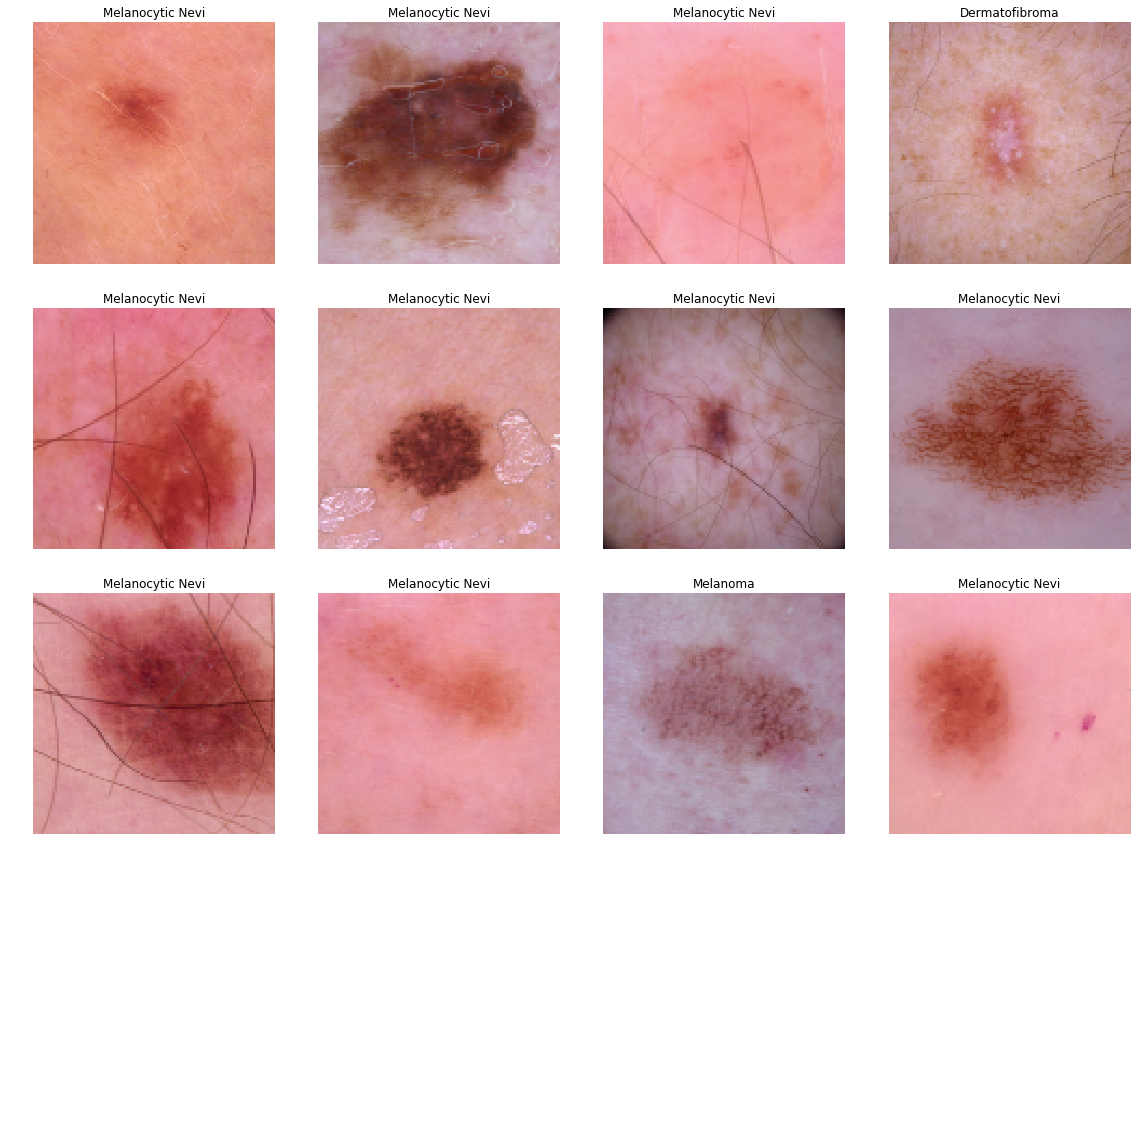

In [6]:
data.show_batch()

### Testing Model: mxresnet (non-pretrained)

In [5]:
# hyper parameters
alpha = 0.99     # alpha
mom = 0.95       # momentum
eps = 1e-6       # epsilon
epochs = 5       # number of epochs
mixup = 0.3        # mixup
sa = 1           # self attention
sym = 0          # symmetry for attention
ann_start = 0.72 # mixup
wd = 1e-2

# optimization, loss
opt_func = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = LabelSmoothingCrossEntropy()

# our arch
# we will be using a xresnet with mish activation
m = mxresnet34

# creating our learner
learn = (Learner(data,                          # databunch
                 m(c_out=data.c, sa=sa, sym=sym),   # model parameters
                 wd=wd,                       # weight decay
                 opt_func=opt_func,             # optimization: ranger
                 metrics=[accuracy, top_k_accuracy], # printed metrics
                 bn_wd=False, true_wd=True,     # batch norm
                 loss_func=loss_func)           # loss function: LabelCrossEntropy
        )

# adding mixup:
if mixup > 0.:
    learn.mixup(alpha=alpha);
# adding mixed precision for training
learn.to_fp16();

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


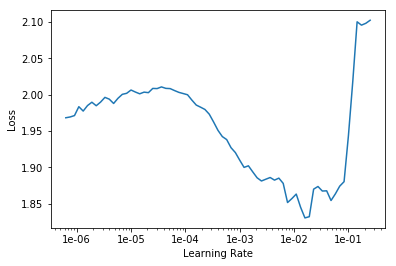

In [7]:
# finding an optimal learning rate
learn.lr_find(wd=wd)
learn.recorder.plot()

In [9]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
"""
batch_size = 12
image_size = 224//2

mxresnet34

lr = 1e-3        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.181093,1.033312,0.713287,0.986014,05:15
1,1.120658,0.968778,0.746254,0.993007,05:17
2,1.097923,0.994584,0.737263,0.989011,05:13
3,1.109889,0.961468,0.757243,0.991009,05:09
4,1.049253,0.893683,0.786214,0.992008,05:10


In [6]:
# ATTEMPT TO REPLICATE RESULTS
"""
batch_size = 12
image_size = 224//2

mxresnet34

lr = 1e-3        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.156582,1.102951,0.679321,0.985015,05:05
1,1.098193,1.066964,0.720280,0.985015,05:11
2,1.125859,1.018186,0.727273,0.990010,05:11
3,1.081445,1.002940,0.760240,0.987013,05:09
4,1.070731,0.947383,0.779221,0.991009,05:10


### BatchSize Experimentation

In [4]:
# 64
bs = 64

data = (ImageList.from_csv(path, 'labels.csv', folder='images', suffix='.jpg')
        # Splitting by 10%
        .split_by_rand_pct(.1)
        # Labeling with col1 = 'lesion'
        .label_from_df(cols=1)
        # Will only use size transformation
        .transform(size=224//2)
        # Turning into our databunch object:
        .databunch(bs=bs, num_workers=1).normalize(imagenet_stats)) 

In [5]:
# hyper parameters
alpha = 0.99     # alpha
mom = 0.95       # momentum
eps = 1e-6       # epsilon
epochs = 5       # number of epochs
mixup = 0.3        # mixup
sa = 1           # self attention
sym = 0          # symmetry for attention
ann_start = 0.72 # mixup
wd = 1e-2

# optimization, loss
opt_func = partial(Ranger, betas=(mom, alpha), eps=eps)
loss_func = LabelSmoothingCrossEntropy()

# our arch
# we will be using a xresnet with mish activation
m = mxresnet34

# creating our learner
learn = (Learner(data,                          # databunch
                 m(c_out=data.c, sa=sa, sym=sym),   # model parameters
                 wd=wd,                       # weight decay
                 opt_func=opt_func,             # optimization: ranger
                 metrics=[accuracy, top_k_accuracy], # printed metrics
                 bn_wd=False, true_wd=True,     # batch norm
                 loss_func=loss_func)           # loss function: LabelCrossEntropy
        )

# adding mixup:
if mixup > 0.:
    learn.mixup(alpha=alpha);
# adding mixed precision for training
learn.to_fp16();

In [6]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
"""
batch_size = 24
image_size = 224//2

model = mxresnet34

lr = 1e-3        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.163684,1.034953,0.709291,0.982018,04:02
1,1.110509,0.994238,0.729271,0.987013,04:22
2,1.114056,0.991653,0.739261,0.984016,04:40
3,1.082564,0.962839,0.744256,0.987013,04:12
4,1.048587,0.931484,0.771229,0.990010,04:03


In [6]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
"""
batch_size = 32
image_size = 224//2

model = mxresnet34

lr = 1e-3        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.145610,1.074761,0.714286,0.982018,03:47
1,1.121754,1.010595,0.735265,0.992008,03:48
2,1.099677,0.957170,0.760240,0.988012,03:54
3,1.095965,0.950318,0.770230,0.990010,03:44
4,1.050725,0.917607,0.778222,0.993007,03:50


In [6]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
"""
batch_size = 64
image_size = 224//2

model = mxresnet34

lr = 1e-3        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-3
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.220927,1.049837,0.713287,0.983017,03:19
1,1.142142,1.031705,0.727273,0.989011,03:25
2,1.108113,0.957621,0.758242,0.991009,03:21
3,1.087642,0.971969,0.773227,0.990010,03:21
4,1.066759,0.936090,0.778222,0.988012,03:17


In [6]:
# learning rate seems fine: lets train!
# we will train with flat and anneal
"""
batch_size = 64
image_size = 224//2

model = mxresnet34

lr = 1e-2        
alpha = 0.99     
mom = 0.95       
eps = 1e-6       
epochs = 5       
mixup = 0.3     
sa = 1           
sym = 0          
ann_start = 0.72 
wd = 1e-2

"""
lr = 1e-2
fit_with_annealing(learn, epochs, lr, ann_start)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.192464,1.019957,0.719281,0.986014,03:26
1,1.144222,1.029074,0.742258,0.982018,03:17
2,1.118698,0.992720,0.748252,0.987013,03:23
3,1.105027,0.948389,0.753247,0.984016,03:20
4,1.081652,0.918393,0.777223,0.988012,03:27
